In [3]:
# run only if you have not installed the next libraries
"""
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install getdist
"""


'\n!pip install numpy\n!pip install matplotlib\n!pip install scipy\n!pip install getdist\n'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as sci
import time
from getdist import plots, MCSamples
import time
%matplotlib inline

# Gradiente de U

$\LARGE U = -\log(L(\textbf{q})p(\textbf{q})) = - \log(L) -  \log(p)$

$\LARGE \nabla_{q} U = -\frac{1}{L}\frac{\partial L}{\partial q} - \frac{1}{p}\frac{\partial p}{\partial q} = -\frac{1}{L}\frac{\partial L}{\partial q}$

Si el prior $p$ es uniforme, $\frac{\partial p}{\partial q} = 0$

$\LARGE \frac{\partial L}{\partial q} = \frac{\partial}{\partial q}(N\exp(-\frac{\chi^{2}}{2})) = -N \chi \exp(-\frac{\chi^{2}}{2})\frac{\partial \chi}{\partial q}$

$\LARGE \frac{\partial \chi}{\partial q} = \frac{\partial}{\partial q}(A - \frac{B^{2}}{C}) = \frac{\partial A}{\partial q} - 2\frac{B}{C} \frac{\partial B}{\partial q}$

$\LARGE \frac{\partial A}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)^{2}}{\sigma_{i}^{2}}) = -\sum_{i}\frac{2(\mu_{i} - \mu)}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\LARGE \frac{\partial B}{\partial q} = \frac{\partial}{\partial q}(\sum_{i}\frac{(\mu_{i} - \mu)}{\sigma_{i}^{2}}) = - \sum_{i} \frac{1}{\sigma_{i}^{2}} \frac{\partial \mu}{\partial q}$

$\LARGE \frac{\partial \mu}{\partial q} = \frac{\partial}{\partial q} (5 \log_{10}(\bar{d}_{L})) = \frac{5}{\log{10}} \frac{1}{\bar{d}_{L}} \frac{\partial \bar{d}_{L}}{\partial q}$

$\LARGE \frac{\partial \bar{d}_{L}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{L}}{d_{H}}) = \frac{1}{d_{H}} \frac{\partial d_{L}}{\partial q}$

$\LARGE \frac{\partial d_{L}}{\partial q} = \frac{\partial}{\partial q}((1 + z)\, d_{M}) = (1 + z)\frac{\partial d_{M}}{\partial q}$

$
\begin{eqnarray}
\frac{\partial\ d_{M}}{\partial q} & = &  \left\{
	\begin{array}{ll}
		\frac{\partial f_{1}}{\partial q} & \mbox{if } \Omega_{k} > 0 \\
		\frac{\partial f_{2}}{\partial q} & \mbox{if } \Omega_{k} = 0 \\
        \frac{\partial f_{3}}{\partial q} & \mbox{if } \Omega_{k} < 0 
	\end{array}
\right.
\end{eqnarray}
$

\begin{align}
        \frac{\partial f_{1}}{\partial q} = \frac{\partial}{\partial q}(\frac{d_{H}}{\sqrt\Omega_{k}}\sinh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E[z']}))\\
        \frac{\partial f_{1}}{\partial q} = d_{H} [-\frac{1}{2}\Omega_{k}^{-3/2}\frac{\partial \Omega_{k}}{\partial q}\sinh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')}) + \Omega_{k}^{-1/2}\cosh(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')})\frac{\partial}{\partial q}(\sqrt{\Omega_{k}}\int_{0}^{z}\frac{dz'}{E(z')})
\end{align}


In [201]:
# Este programa implementa Hamiltonian Markov Chain Monte Carlo. El núcleo utilizado se basa en Metropolis Hastings.

def likelihood(mod, dat, sigma): # retorna escalar, log(L)
    sig = np.diagonal(sigma)
    L = -0.5*chi2(mod, dat, sigma)[0]  + np.sum(-0.5*np.log(2*np.pi*sig**2))
    #pp = np.argwhere((a1==-np.inf))
    #a1[pp] = 0
    return L


def chi2(mod, dat, sigma):
    sig = np.diagonal(sigma)
    AA = np.sum(((dat - mod)/sig)**2)
    BB = np.sum((dat - mod)/sig**2)	
    CC = np.sum(1/sig**2)
    chi = AA - (BB**2)/CC
    return chi, BB/CC


def prior(theta): # log(pi)
    ct = 1
    r = np.diag(np.ones(len(theta))*ct)
    p = -0.5*np.log(np.linalg.det(2*np.pi*r)) - 0.5*theta.dot((np.linalg.inv(r)).dot(theta)) 
    return p


def acepta(ec, ep, EC, EP, x, X):
    alpha = min(- EP - EC + ep + ec, 0) # log(alpha)
    u = np.log(np.random.uniform())
    if u<alpha:
        return X, EP
    else:
        return x, ep


def EHubble(theta, z): # parametro de hubble
    om0 = theta[0]
    ol = theta[1]
    w = theta[2]
    arg = om0*(1 + z)**3 + (1 - om0 - ol)*(1 + z)**2 + ol*(1 + z)**(3*(1 + w))
    EE = np.sqrt(arg)
    return EE, arg


def modelo(theta, z): # modulo de la distancia teorico
    om0 = theta[0]
    ol = theta[1]
    #print(om0, ol)
    omega_k = 1 - om0 - ol
    #print(omega_k)
    E = EHubble(theta, z)[0]
    I = sci.cumtrapz(1/E, z, initial=0)+z[0]*((1/E)[0] + 1)/2
    o_k_s = np.sqrt(abs(omega_k))
    if omega_k==0:
        dl = (1 + z)*I
    elif omega_k<0:
        dl = (1 + z)*np.sin(o_k_s*I)/o_k_s
    elif omega_k>0:	
        dl = (1 + z)*np.sinh(o_k_s*I)/o_k_s	
    dist = 5*np.log10(dl + 1e-300) # estabilidad numerica
    #if (-np.inf==dist).any(): 
    #    print(theta)
    return dist


def tasa(tant, tpos):
    l = len(tant)
    if np.sum(tant==tpos)==l:
        c = 0
    else:
        c = 1
    return c


def revisa(theta, z):
    arg = EHubble(theta, z)[1]
    bol = np.sum(arg<0)
    print(bol)
    if bol>0:
        a = 0 # raiz imaginaria 
    else:
        a = 1 # raiz real
    return a


def argmin2(t1, t2, t3, V): # busca en base a vector chi2 y devulve minimos de los parametros
    amin = np.argmin(V)
    return t1[amin], t2[amin], t3[amin]


def potencial(dat, sigma, theta, z):
    mod = modelo(theta, z)
    u = - likelihood(mod, dat, sigma) - prior(theta) 
    return u


def cinetica(p, m):
    k = np.sum(p**2/2/m)
    return k


def hamiltoniano(p, dat, sigma, theta, z, m=1):
    h = cinetica(p, m) + potencial(dat, sigma, theta, z)
    return h


def gradiente(dw, theta, z, dat, sigma):

    tf = theta + theta*dw
    tb = theta - theta*dw
    grad = (potencial(dat, sigma, tf, z) - potencial(dat, sigma, tb, z))/(2*dw)
    return grad


def leapfrog(l, e, dw, theta, m, z, dat, sigma):

    qe = theta
    while True:

        pi = np.random.multivariate_normal(mean=np.zeros(3), cov=np.diag(m))
        pe = pi
        X = []
        P = []
        X.append(theta)
        P.append(pe)
        for i in range(l):
  
            #print(i)
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break            
            #print('ant pe', pe)
            #print('ant qe', qe)
            #print('grad', gradiente(dw, qe, z, dat, sigma))
            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma) # actualiza momento en e/2
            
            #print('desp pe', pe)
            
            qe = qe + e*pe/m
            if qe[0]<0:
                qe[0] = qe[0]*-1
                pe[0] = pe[0]*-1
            if qe[1]<0:
                qe[1] = qe[1]*-1
                pe[1] = pe[1]*-1
            if qe[2]>1/3:
                qe[2] = 1/3 - qe[2]
                pe[2] = pe[2]*-1
      
            #rev = revisa1(qe)*revisa1(qe + dw)*revisa1(qe - dw) # revisa(qe, z)*revisa(qe + 0.5*dw, z)*revisa(qe - 0.5*dw, z)
            #print(rev)
            #if rev:
            #    break

            pe = pe - 0.5*e*gradiente(dw, qe, z, dat, sigma)

            P.append(pe)
            X.append(qe)
            if i + 1==l: 
                i += 1
        if i==l: 
            break

    P = np.array(P)
    X = np.array(X)
    return X, P


def revisa1(X):
    x = X[0]
    y = X[1]
    z = X[2]
    xlim = np.array([0, 1])
    ylim = xlim
    zlim = np.array([-np.inf, 1/3])
    if xlim[0]<x<xlim[1] and ylim[0]<y<ylim[1] and zlim[0]<z<zlim[1]:
        return 1
    else:
        return 0
    
    
def HMC(modelo, datos, ds, dg, N, L, params, cov, q0):
    """
    datos: X, F(X)
    params: ['p1', 'p2', ..., 'pn']
    cov: matriz de covarianza de datos
    """
    # Matrices de datos de la cadena
    X = datos[0]
    Y = datos[1]
    chain = [] 
    post = [] 
    chi_2 = []
    Ratio = []
    H = []
    acept = 0
    mod1 = modelo(q0, X)
    pos1 = potencial(Y, cov, q0, X)
    Chi1 = chi2(mod1, Y, cov)[0]
    chain.append(q0)
    post.append(pos1)
    chi_2.append(Chi1)
    Ratio.append(100)

    Ti = time.time()
    for i in range(N):
        
        q = chain[i]
        #print(q)
        # revision si proposal no indefine la busqueda
        #Q, P = leapfrog(L, ps, pg, q, m, redshift, mu_obs, cov)
        #Q1 = Q[-1]
        #P1 = P[-1]

        while True:
            Q, P = leapfrog(L, ds, dg, q, m, X, Y, cov)
            Q1 = Q[-1]
            P1 = P[-1]
            if revisa1(Q1):
                break
            #if revisa(Q1, redshift)==1: # que la raiz no sea imaginaria
             #   break

        H.append(Q)
        t = cinetica(P1[0], m)
        u = potencial(Y, cov, q, X)
        T = cinetica(P1, m)
        U = potencial(Y, cov, Q1, X)
        A = acepta(t, u, T, U, q, Q1)
        chain.append(A[0])
        post.append(A[1])
        mod1 = modelo(A[0], X)
        Chi1 = chi2(mod1, Y, cov)[0]
        chi_2.append(Chi1)
        # ratio de aceptacion
        acept += tasa(chain[i], chain[i + 1]) 
        Ratio.append(acept/(i+1)*100)
        if i%100==0:
            print(i)
            print('ratio', Ratio[i])
    

    Tf = time.time()
    print('Tiempo cadena', np.around(Tf - Ti, 0), 's')

    ratio = acept/N*100
    print('ratio %', np.rint(ratio))

    post = np.array(post)
    chain = np.array(chain)
    chi_2 = np.array(chi_2)
    Ratio = np.array(Ratio)
    H = np.array(H)

    t1 = chain[:,0]
    t2 = chain[:,1]
    t3 = chain[:,2]

    # busca argumento del minimo de chi2
    t1m, t2m, t3m = np.around(argmin2(t1, t2, t3, chi_2),3)
    mins = [t1m, t2m, t3m]
    muestras = {}
    for i in range(len(params)):
        muestras[params[i]] = chain[:, i]
    return muestras, Ratio, chi_2, post, mins

In [6]:
# saved things directory
direc = '/home/mauricio/Documents/Uni/Intro_2/' + 'gal.txt'

# Carga de datos
redshift = np.genfromtxt('gal.txt', usecols=(1))
mu_obs = np.genfromtxt('gal.txt', usecols=(2)) # m - M
cov = np.genfromtxt('gal.txt', usecols=(3))

p = np.argsort(redshift)
redshift = redshift[p]
mu_obs = mu_obs[p]
cov = cov[p]
cov = np.diag(cov)

In [11]:
# configuracion cadena

# params
labs = [r'$\Omega_{m}$', r'$\Omega_{\Lambda}$', r'w']
labs1 = [r'\Omega_{m}', r'\Omega_{\Lambda}', r'w']

M = -19.3182761161
Chains = []
Xi2 = []
Post = []
COV = []
params = 3 # numero de parametros
r = 0.75e-2 #0.75e-2
m = np.array([1, 1, 1])*1e-5  # np.ones(3)*r # (np.array([0.4, 1.125, 4])**2)*1e-2  
pg = 1e-4 # paso gradiente # 1e-4
ps = pg*10 # paso solver
'numero de parametros', params
L = 5
print('pasos solver:', L)
q = np.random.uniform(low=[0,0,-5], high=[1, 1, 1/3], size=3)


pasos solver: 5


In [12]:
#Get the getdist MCSamples objects for the samples, specifying same parameter
#names and labels; if not specified weights are assumed to all be unity
ndim = 3
names = ["x%s"%i for i in range(ndim)]
labels = ["x_%s"%i for i in range(ndim)]
samps = np.vstack((t1, t2, t3)).T
samples = MCSamples(samples=samps, names=labs1, labels=labs1)

#Triangle plot
g = plots.getSubplotPlotter()
samples.updateSettings({'contours': [0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 3
g.triangle_plot([samples], filled=True)

NameError: name 't1' is not defined

In [203]:
ds = 1e-3
q0 = np.random.uniform(low=[0,0,-5], high=[1, 1, 1/3], size=3)
print('q0', q0)
m = np.array([1, 1, 1])*1e-1
R = HMC(modelo, [redshift, mu_obs], ds=ds, dg=ds*1e-1, N=10000, L=10, params=['om', 'ol', 'w'], cov=cov, q0=q0)


q0 [ 0.9797393   0.27721854 -3.32322602]
0
ratio 100
100
ratio 48.0
200
ratio 52.0
300
ratio 50.66666666666667
400
ratio 52.0
500
ratio 54.800000000000004
600
ratio 53.166666666666664
700
ratio 52.0
800
ratio 50.625
900
ratio 50.77777777777778
1000
ratio 50.6
1100
ratio 49.81818181818182
1200
ratio 48.833333333333336
1300
ratio 47.84615384615385
1400
ratio 47.785714285714285
1500
ratio 47.66666666666667
1600
ratio 46.9375
1700
ratio 45.88235294117647
1800
ratio 45.22222222222222
1900
ratio 44.315789473684205
2000
ratio 43.45
2100
ratio 42.61904761904762
2200
ratio 42.18181818181818
2300
ratio 41.56521739130435
2400
ratio 40.666666666666664
2500
ratio 40.2
2600
ratio 39.57692307692307
2700
ratio 39.07407407407407
2800
ratio 38.17857142857143
2900
ratio 37.41379310344828
3000
ratio 36.666666666666664
3100
ratio 36.12903225806451
3200
ratio 35.4375
3300
ratio 34.63636363636364
3400
ratio 33.970588235294116
3500
ratio 33.4
3600
ratio 32.77777777777778
3700
ratio 32.08108108108108
3800
rati

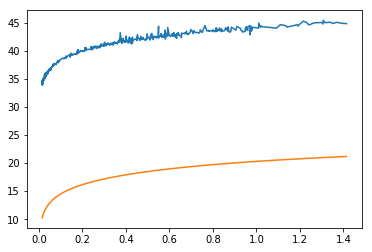

In [188]:
fx = modelo(np.array(R[4]), redshift)
plt.plot(redshift, mu_obs)
plt.plot(redshift, fx - M)

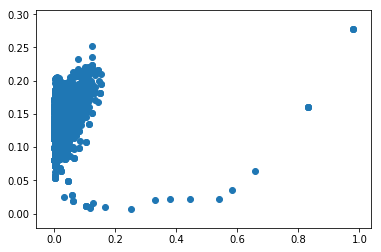

In [204]:
plt.scatter(R[0]['om'], R[0]['ol'])

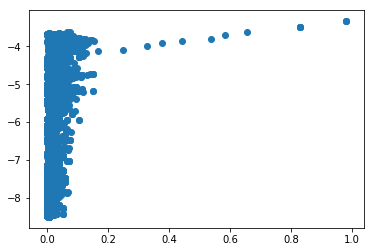

In [205]:
plt.scatter(R[0]['om'], R[0]['w'])

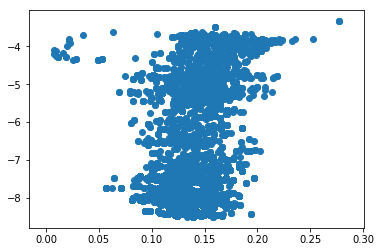

In [206]:
plt.scatter(R[0]['ol'], R[0]['w'])

In [ ]:
xr = np.linspace(0, 1, 20)
yr = np.linspace(0, 1, 20)
zr = np.linspace(-30, -1/3, 20)
Us = np.zeros((len(xr), len(yr), len(zr)))
for i in range(len(xr)):
    for j in range(len(yr)):
        for k in range(len(zr)):
            theta = np.array([xr[i], yr[j], zr[k]])
            pot = potencial(mu_obs, cov, theta, redshift)
            Us[i][j][k] = pot


In [ ]:
plt.imshow(Us[:][:][5], origin='lower')

q0 [ 0.5  0.5 -1. ]


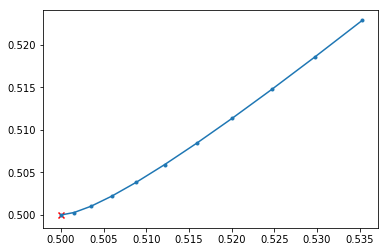

In [181]:
ds = 1e-3
m = np.array([1, 1, 10])*1e-1
print('q0', q0)
X, P = leapfrog(l=10, e=ds, dw=ds*1e-1, theta=q0, m=m, z=redshift, dat=mu_obs, sigma=cov)
plt.plot(X[:, 0], X[:, 1], marker='.')
plt.scatter(X[0, 0], X[0, 1], marker='x', color='red')

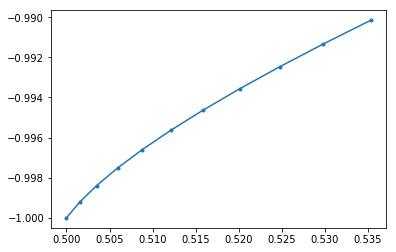

In [182]:
plt.plot(X[:, 0], X[:, 2], marker='.')

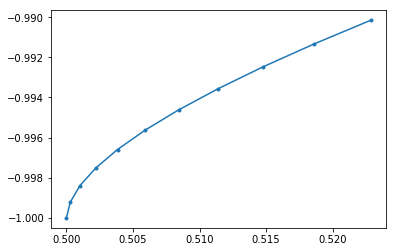

In [183]:
plt.plot(X[:, 1], X[:, 2], marker='.')

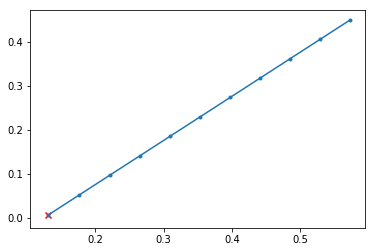

In [184]:
plt.plot(P[:, 0], P[:, 1], marker='.')
plt.scatter(P[0, 0], P[0, 1], marker='x', color='red')

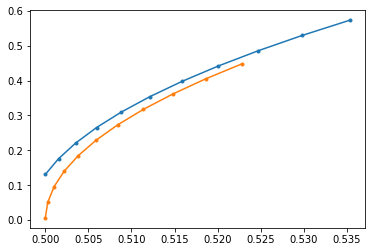

In [185]:
plt.plot(X[:, 0], P[:, 0], marker='.')
plt.plot(X[:, 1], P[:, 1], marker='.')
#plt.plot(X[:, 2], P[:, 2], marker='.')

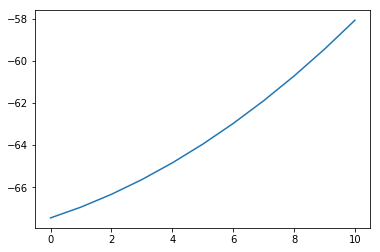

In [186]:
HH = []
for i in range(len(X)):
    hh = hamiltoniano(p=P[i], dat=mu_obs, sigma=cov, theta=X[i], z=redshift, m=m)
    HH.append(hh)
plt.plot(HH)